In [1]:
import gc
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
# import dask.dataframe as dd
from tqdm import tqdm, tnrange
import matplotlib.pyplot as plt


In [2]:
dp = "/data/data/UsedCarPrice"

In [3]:
%time data = pd.read_csv(f"{dp}/used_car_train_20200313.csv", sep=" ")
data.head()


CPU times: user 1.31 s, sys: 91.9 ms, total: 1.4 s
Wall time: 1.41 s


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [4]:
%time test = pd.read_csv(f"{dp}/used_car_testB_20200421.csv", sep=" ")
test.head()


CPU times: user 332 ms, sys: 15.9 ms, total: 348 ms
Wall time: 346 ms


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,...,0.236520,0.000241,0.105319,0.046233,0.094522,3.619512,-0.280607,-2.019761,0.978828,0.803322
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,...,0.261518,0.000000,0.120323,0.046784,0.035385,2.997376,-1.406705,-1.020884,-1.349990,-0.200542
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,...,0.261691,0.090836,0.000000,0.079655,0.073586,-3.951084,-0.433467,0.918964,1.634604,1.027173
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,...,0.236050,0.101777,0.098950,0.026830,0.096614,-2.846788,2.800267,-2.524610,1.076819,0.461610
4,200004,76998,20030301,46.0,6,0.0,NaN,0.0,116,15.0,...,0.257000,0.000000,0.066732,0.057771,0.068852,2.839010,-1.659801,-0.924142,0.199423,0.451014


In [5]:
%time data = data[data['seller'] != 1]


CPU times: user 16.1 ms, sys: 7.92 ms, total: 24 ms
Wall time: 22.6 ms


In [6]:


def fdatetime(t):
    t = t if t%1000 >= 100 else t+100
    return datetime.datetime.strptime(str(t),'%Y%m%d')


def fvar(dt, vl0=None, vl1=None):
    dt['power'] = dt['power'].apply(lambda x: 600 if x > 600 else x)
    
    val, nval = [], []
    top = 1000
    cut1, cut2 = 0.10, 0.50
    dt = dt.copy()
    
    dt["t1"] = dt["regDate"].apply(fdatetime)
    dt["t2"] = dt["creatDate"].apply(fdatetime)
    dt["t3"] = datetime.datetime(2017,1,1)
    
    dt["t1y"] = dt["t1"].apply(lambda x: x.year)
    dt["t2y"] = dt["t2"].apply(lambda x: x.year)
    dt["t1m"] = dt["t1"].apply(lambda x: x.month)
    dt["t2m"] = dt["t2"].apply(lambda x: x.month)
    dt["t1w"] = dt["t1"].apply(lambda x: x.weekday())
    dt["t2w"] = dt["t2"].apply(lambda x: x.weekday())

    dt["t21"] = [(d1-d2).days for d1, d2 in zip(dt["t2"], dt["t1"])]
    dt["tN1"] = [(d1-d2).days for d1, d2 in zip(dt["t3"], dt["t1"])]
    dt["tN2"] = [(d1-d2).days for d1, d2 in zip(dt["t3"], dt["t2"])]
    val.extend(["t21", "tN1", "tN2"])
    
    for i in tnrange(0, 15):
        val.append(f"v_{i}")
        
        dmax, dmin, dmed, davg = dt[f"v_{i}"].max(), dt[f"v_{i}"].min(), dt[f"v_{i}"].median(), dt[f"v_{i}"].mean()
        dt[f"f_v_{i}"] = dt[f"v_{i}"].apply(lambda x: (x-dmin)/(dmax-dmin))
        dt[f"l_v_{i}"] = dt[f"v_{i}"].apply(lambda x: np.log(x))
        dt[f"m1_v_{i}"] = dt[f"v_{i}"].apply(lambda x: 1 if x > dmed else 0)
        dt[f"m2_v_{i}"] = dt[f"v_{i}"].apply(lambda x: 1 if x > davg else 0)
        val.extend([f"f_v_{i}", f"l_v_{i}", f"m1_v_{i}", f"m2_v_{i}"])
    
    for i in tqdm(["power", "kilometer"]):
        val.append(i)
        
        dmax, dmin, dmed, davg = dt[i].max(), dt[i].min(), dt[i].median(), dt[i].mean()
        dt[f"f_{i}"] = dt[i].apply(lambda x: (x-dmin)/(dmax-dmin))
        dt[f"l_{i}"] = dt[i].apply(lambda x: np.log(x))
        dt[f"m1_{i}"] = dt[i].apply(lambda x: 1 if x > dmed else 0)
        dt[f"m2_{i}"] = dt[i].apply(lambda x: 1 if x > davg else 0)
        val.extend([f"f_{i}", f"l_{i}", f"m1_{i}", f"m2_{i}"])
        
    il = [
        "model", "brand", "bodyType", "fuelType",
        "gearbox", "notRepairedDamage", "regionCode", "seller",
        "t1y", "t2y", "t1m", "t2m", "t1w", "t2w"
    ]
    for i in tqdm(il):
        if i == "notRepairedDamage":
            dt[i] = dt[i].apply(lambda x: {'0.0': 0, '1.0': 1, "-": 2}[x])
        val.append(i)
        
        dt[f"s_{i}"] = 0
        for jk, jv in enumerate(pd.value_counts(dt[i]).head(top).index):
            dt[f"f_{jk}_{i}"] = dt[i].apply(lambda x: 1 if x == jv else 0)
            dt[f"fn_{jk}_{i}"] = dt[i].apply(lambda x: 1 if x != jv else 0)
            dt[f"s_{i}"] = dt[f"s_{i}"] + dt[f"f_{jk}_{i}"]
            
            val.extend([f"f_{jk}_{i}", f"fn_{jk}_{i}"])
        
        dt[f"o_{i}"] = dt[f"s_{i}"].apply(lambda x: 0 if x >= 1 else 1)
        val.extend([f"o_{i}", f"s_{i}"])
    
    dt.fillna(-1, inplace=True)
    
    t_ = []
    dt_ = dt[-dt["price"].isna()].copy()
    
    for i in tqdm(val):
        if np.corrcoef(dt_[i], dt_["price"])[:,0][1] > cut1:
            t_.append(i)
    
    for i in tqdm(t_):
        for j in t_:
            if i != j:
                dt_[f"{i}@1{j}"] = dt_[i] * dt_[j]
                if np.corrcoef(dt_[f"{i}@1{j}"], dt_["price"])[:,0][1] > cut2:
                    nval.append(f"{i}@1{j}")

                dt_[f"{i}@2{j}"] = dt_[i] + dt_[j]
                if np.corrcoef(dt_[f"{i}@2{j}"], dt_["price"])[:,0][1] > cut2:
                    nval.append(f"{i}@2{j}")
                
                dt_[f"{i}@3{j}"] = dt_[i] - dt_[j]
                if np.corrcoef(dt_[f"{i}@3{j}"], dt_["price"])[:,0][1] > cut2:
                    nval.append(f"{i}@3{j}")
                
    del dt_
    
    for ij in tqdm(nval):
        for ito in ["@1", "@2", "@3"]:
            if ito in ij:
                [i, j] = ij.split(ito)
                dt[f"{i}{ito}{j}"] = dt[i] * dt[j]
    return val, nval, dt

d_ = pd.concat([data.sample(1000), test], sort=True)
%time dval, dnval, d_ = fvar(d_)
data_, test_ = d_[d_["price"] > 0], d_[d_["price"] < 0]
del d_
len(dval), len(dnval)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2858 [00:00<?, ?it/s]/data/soft/py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/data/soft/py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/soft/py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 2858/2858 [00:02<00:00, 1001.08it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


CPU times: user 1min 40s, sys: 13.1 s, total: 1min 53s
Wall time: 1min 53s


(2858, 0)

In [7]:
# data['price'] = np.log1p(data['price'])

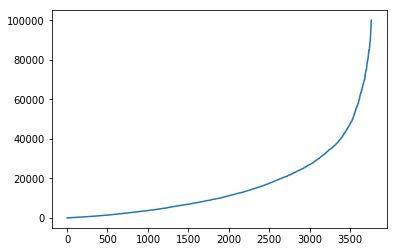

In [8]:
# 
price = [i for i in pd.value_counts(data['price']).keys()]
price.sort()
plt.plot(price)


In [9]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 80483 to 75750
Columns: 2867 entries, SaleID to o_t2w
dtypes: datetime64[ns](3), float64(55), int64(2809)
memory usage: 21.9 MB


In [10]:
test_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 2867 entries, SaleID to o_t2w
dtypes: datetime64[ns](3), float64(55), int64(2809)
memory usage: 1.1 GB


In [11]:
%time data_.isna().values.any()


CPU times: user 3.33 ms, sys: 1.92 ms, total: 5.25 ms
Wall time: 3.86 ms


False

In [12]:
%time test_.isna().values.any()


CPU times: user 95.7 ms, sys: 107 ms, total: 203 ms
Wall time: 201 ms


False

In [13]:
%time data_.isnull().values.any()


CPU times: user 4.14 ms, sys: 898 µs, total: 5.04 ms
Wall time: 3.72 ms


False

In [14]:
%time test_.isnull().values.any()


CPU times: user 99.3 ms, sys: 105 ms, total: 204 ms
Wall time: 203 ms


False

/data/soft/py3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


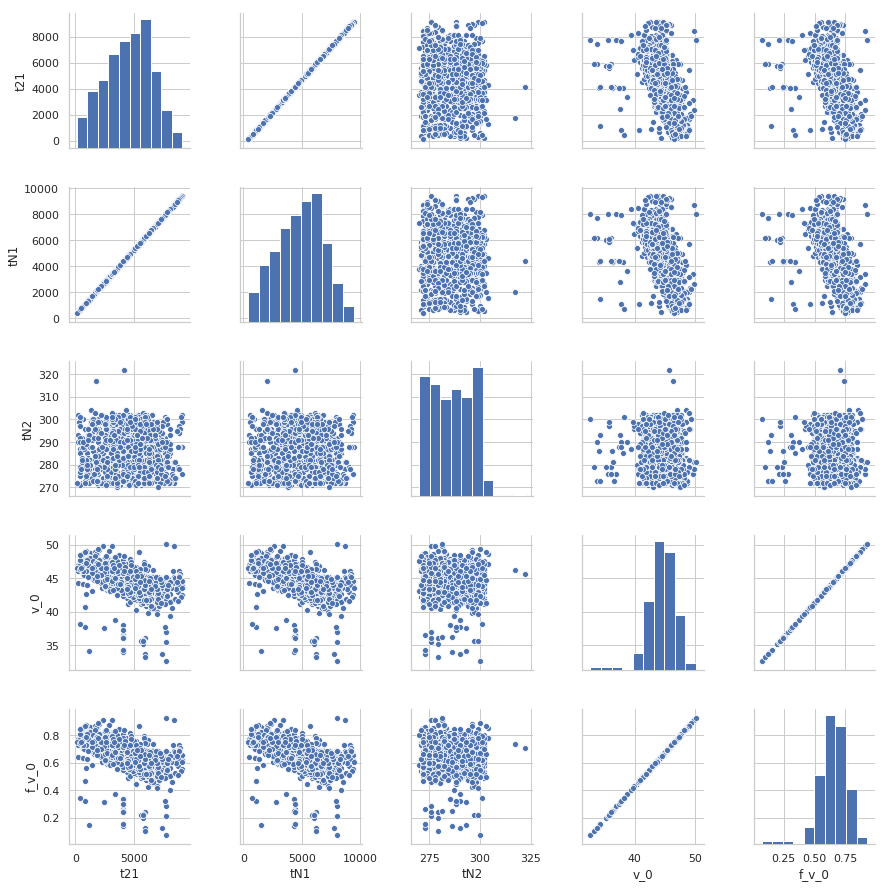

In [15]:
cols = dval[:5]

sns.set(style='whitegrid', context='notebook')
sns.pairplot(data_[cols], size=2.5)
plt.tight_layout()
plt.savefig('../outs/seaborn001.png')
plt.show()


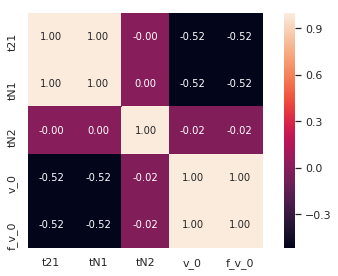

In [16]:

cm = np.corrcoef(data_[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(
    cm,cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 10},
    yticklabels=cols,
    xticklabels=cols
)
plt.tight_layout()
plt.savefig('../outs/seaborn002.png')
plt.show()


In [17]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics


/data/soft/py3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
import xgboost as xgb
help(xgb.XGBRegressor())

Help on XGBRegressor in module xgboost.sklearn object:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(objective='reg:squarederror', **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of gradient boosted trees.  Equivalent to number of boosting
 |          rounds.
 |  
 |      max_depth : int
 |          Maximum tree depth for base learners.
 |      learning_rate : float
 |          Boosting learning rate (xgb's "eta")
 |      verbosity : int
 |          The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |      objective : string or callable
 |          Specify the learning task and the corresponding learning objective or
 |          a custom objective function to be used (see note below).
 |      booster: string
 |          Specify which booster to use: gbtree, gblinear or dart.
 |      tree_method: string
 |          Spe

```
445.619825, 431.537753, 438.578789

647.6021
    60000, frac=0.75
    model = xgb.XGBRegressor(
        n_estimators=600, 
        learning_rate=0.2, 
        gamma=0, 
        subsample=0.8,
        colsample_bytree=0.9, 
        max_depth=6,
        objective='reg:squarederror',
        reg_alpha=1,
        reg_lambda=1,
    )
```

In [19]:
# fdt = lambda x: min(max(float(np.expm1(x)),10),99999)

fdt = lambda x: min(max(float(x),10),99999)


In [20]:

v1l = dval
# v1l = dnval

%time m = data_.sample(frac=0.75)[v1l + ["price"]]
print(m.shape)
m_y = m[["price"]]
m_x = m[v1l]

X_trai, X_test, y_trai, y_test = train_test_split(m_x, m_y, test_size=0.3)
print(X_trai.shape, X_test.shape, y_trai.shape, y_test.shape)

def xgb_xgbregressor(train_x, train_y):
    import xgboost as xgb
    model = xgb.XGBRegressor(
        n_estimators=600, 
        learning_rate=0.2, 
        gamma=0, 
        subsample=0.8,
        colsample_bytree=0.9, 
        max_depth=6,
        objective='reg:squarederror',
        reg_alpha=1,
        reg_lambda=1,
    )
    model.fit(train_x, train_y)
    return model

Xmodel = xgb_xgbregressor
if Xmodel.__name__ == "xgb_xgbregressor":
    print(f"\n>>> {Xmodel.__name__}")
    %time model1 = Xmodel(X_trai, y_trai) 
    %time y_trai_m = [fdt(i) for i in model1.predict(X_trai)]
    %time y_test_m = [fdt(i) for i in model1.predict(X_test)]



CPU times: user 22.6 ms, sys: 1.96 ms, total: 24.6 ms
Wall time: 24.7 ms
(750, 2859)
(525, 2858) (225, 2858) (525, 1) (225, 1)

>>> xgb_xgbregressor
CPU times: user 1min 4s, sys: 1.91 s, total: 1min 6s
Wall time: 19.7 s
CPU times: user 492 ms, sys: 44.5 ms, total: 536 ms
Wall time: 156 ms
CPU times: user 264 ms, sys: 21.4 ms, total: 285 ms
Wall time: 85.9 ms


In [21]:

mr1 = metrics.mean_absolute_error(y_trai, y_trai_m)
mr2 = metrics.mean_absolute_error(y_test, y_test_m)
print("%.6f, %.6f, %.6f" % (mr1, mr2, np.mean([mr1, mr2])))


0.030790, 913.652624, 456.841707


In [22]:
%time m = data_.sample(frac=1)[v1l + ["price"]]
print(m.shape)
m_y = m[["price"]]
m_x = m[v1l]

X_trai, X_test, y_trai, y_test = train_test_split(m_x, m_y, test_size=0.5)
%time y_trai_m = [fdt(i) for i in model1.predict(X_trai)]
%time y_test_m = [fdt(i) for i in model1.predict(X_test)]

mr1 = metrics.mean_absolute_error(y_trai, y_trai_m)
mr2 = metrics.mean_absolute_error(y_test, y_test_m)
print("%.6f, %.6f, %.6f" % (mr1, mr2, np.mean([mr1, mr2])))


CPU times: user 92.2 ms, sys: 11.4 ms, total: 104 ms
Wall time: 33.5 ms
(1000, 2859)
CPU times: user 239 ms, sys: 14.7 ms, total: 254 ms
Wall time: 130 ms
CPU times: user 391 ms, sys: 20.4 ms, total: 412 ms
Wall time: 135 ms
412.281365, 669.435314, 540.858340


In [23]:
result = pd.DataFrame()
result["SaleID"] = test_.SaleID
result["price"] = [fdt(i) for i in model1.predict(test_[v1l])]
result.to_csv("../outs/resultl001.csv",index=False)
result.head()


,SaleID,price
0,200000,1087.560303
1,200001,1917.206665
2,200002,7186.919434
3,200003,1357.479858
4,200004,2273.001465


In [24]:
# 

In [25]:

v2l = dnval

%time m = data_.sample(frac=0.05)[v2l + ["price"]]
print(m.shape)
m_y = m[["price"]]
m_x = m[v2l]

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


def tf_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(v2l)]),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.01)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

model2 = tf_model()
print(model2.summary())


# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('>', end='')
        if epoch % 100 == 0: 
            print('')
        

# 
EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

%time history = model2.fit(m_x,m_y,epochs=EPOCHS,validation_split=0.2,verbose=0,callbacks=[early_stop, PrintDot()])


CPU times: user 3.93 ms, sys: 993 µs, total: 4.92 ms
Wall time: 4.4 ms
(50, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 9,497
Trainable params: 9,497
Non-trainable params: 0
_________________________________________________________________
None
>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

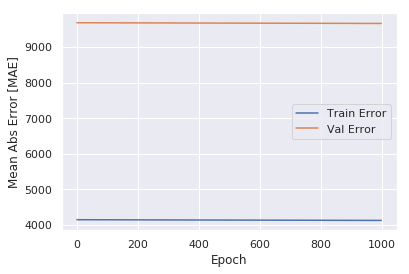

In [26]:
import matplotlib.pyplot as plt


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.legend()

plot_history(history)


In [27]:
%time m = data_.sample(frac=1)[v2l + ["price"]]
print(m.shape)
m_y = m[["price"]]
m_x = m[v2l]

X_trai, X_test, y_trai, y_test = train_test_split(m_x, m_y, test_size=0.3)
%time y_trai_m = [fdt(i) for i in model2.predict(X_trai)[:,0]]
%time y_test_m = [fdt(i) for i in model2.predict(X_test)[:,0]]

mr1 = metrics.mean_absolute_error(y_trai, y_trai_m)
mr2 = metrics.mean_absolute_error(y_test, y_test_m)
print("%.6f, %.6f, %.6f" % (mr1, mr2, np.mean([mr1, mr2])))


CPU times: user 26.1 ms, sys: 22.1 ms, total: 48.3 ms
Wall time: 16.2 ms
(1000, 1)
CPU times: user 225 ms, sys: 22 ms, total: 247 ms
Wall time: 222 ms
CPU times: user 13.3 ms, sys: 1.17 ms, total: 14.5 ms
Wall time: 12.2 ms
5946.911076, 5507.394885, 5727.152980


In [28]:
result = pd.DataFrame()
result["SaleID"] = test_.SaleID
result["price"] = [fdt(i) for i in model2.predict(test_[v2l])[:,0]]
result.to_csv("../outs/resultl002.csv",index=False)
result.head()


,SaleID,price
0,200000,20.091782
1,200001,20.091782
2,200002,20.091782
3,200003,20.091782
4,200004,20.091782


In [29]:
# 